In [19]:
#Imports
import numpy as np
import scipy as sp
import iminuit
import healpy as hp
import histlite as hl
import csky as cy
import os
import gc
from glob import glob

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
class BinnedTemplateAllSky:
    """For conducting binned calculations using maximum likelihood statistical methods. 
    For binned sky map of IceCube event data. No separation of likelihood across declinations.
    
    
    """
    def __init__(self, data, sig, grl, is_binned=False, savedir=None, name='AllSkyBinnedTemplateAnalysis', 
                 template=None, gamma=2.7, cutoff=None, 
                 nside=128, min_dec_deg=-80, max_dec_deg=80, 
                 verbose=False):
        """BinnedTemplateAllSky constructor
        
        Args:
            data: Path to numpy array(s) (directory or single file) containing  dtype=[('run', '<i8'), 
                                                 ('event', '<i8'),
                                                 ('subevent', '<i8'),
                                                 ('ra', '<f8'),
                                                 ('dec', '<f8'),
                                                 ('azi', '<f8'),
                                                 ('zen', '<f8'),
                                                 ('time', '<f8'),
                                                 ('logE', '<f8'),
                                                 ##('angErr', '<f8')])
                                                 
                OR: Path to numpy array of binned data (in this case, set is_binned=True)
                                     
            sig: Path to numpy array containing  dtype = [('run', int), 
                                                 ('event', int), 
                                                 ('subevent', int),
                                                 ('ra', float), 
                                                 ('dec', float),
                                                 ('true_ra', float), 
                                                 ('true_dec', float),
                                                 ('azi', float), 
                                                 ('zen', float), 
                                                 ('time', float),
                                                 ('logE', float), 
                                                 ('true_angErr', float), 
                                                 ('oneweight', float),     
                                                 ('true_energy', float)]
            
            grl: Path to numpy array with GRL runs
                                     
            is_binned: boolean, True if argument data is an array of binned_data, otherwise False (data will be binned)
            
            savedir: path to directory to save binned data. Default: None (don't save)
            
            name: unique name to identify analysis (used in file names when saving)
            
            template: path to template object/array or None
                TO DO:
                    * Rescale template nside for differing energy ranges
                                                            
            gamma: spectral index for detector acceptance and injections. 
                  #This should match the one used to create
                  #the template if using one saved by csky. 
                    
            cutoff: minimum template value to be considered an On bin
                TO DO (???):
                    * Implementation without need for cutoff???

            nside: integer for healpy nside (Default: 128)
                TO DO: 
                    * Allow nside to differ for different energy ranges
                        
            min_/max_dec_deg: min and max declination in degrees for likelihood calculations.
            
            verbose: True for lots of output (Default: False)
            
            
        """
        if template is None:
            raise NotImplementedError('Current implementation can only perform template analysis!')
        elif cutoff is None:
            raise NotImplementedError('Current implementation requires a cutoff to define on/off bins!')
        
        print('Setting up:')
        
        self.name = name
        self.savedir = savedir
        cy.utils.ensure_dir(savedir)
        
        self.verbose = verbose
        
        self.gamma = gamma
        self.cutoff = cutoff
        self.nside = nside
        self.min_dec_deg = min_dec_deg
        self.max_dec_deg = max_dec_deg
        
        self.bin_thetas, self.bin_phis = hp.pix2ang(self.nside, np.arange(hp.nside2npix(self.nside))) 
        self.bin_ras = self.bin_phis
        self.bin_decs = np.pi/2.0 - self.bin_thetas
        
        self.grl = np.load(grl)
        
        if is_binned:
            self.binned_data = np.load(data)
            print(f'Load binned data <-- {data}')
            print(f'    Binned data loaded: Contains {len(self.binned_data)} bins with {np.sum(self.binned_data)} counts')
            if len(self.binned_data) != hp.nside2npix(self.nside):
                raise ValueError(f"Nside of loaded binned data is {hp.npix2nside(len(self.binned_data))}, but given nside is {self.nside}! You need to rebin your data.")
                
        else:
            self.load(data)
        
        self.sig_evs = np.load(sig)
        print(f'Load signal array <-- {sig}')        
        weights = self.sig_evs['oneweight'] * self.sig_evs['true_energy']**(-self.gamma)
        smooth_sig = self.weighted_quantile(self.sig_evs['true_angErr'], weights, 0.5)
        print(f'    Median true angular error: {smooth_sig}')
        
        print(f'Load template <-- {template}')
        template = np.load(template, allow_pickle=True)
        
        
        if template.dtype == 'O':
            self.template = template.item()['template']
            if len(self.template) != hp.nside2npix(self.nside):
                print(f'Template nside does not match nside argument:')
                print(f'    Template: {hp.npix2nside(len(self.template))} --> Argument: {self.nside}')
                print('Adjusting resolution of template and making smoothed PDF... \n')
                
                self.template = hp.ud_grade(self.template, self.nside)
                self.create_template_pdf(smooth_sig)
                
            else:
                sigmas = np.radians(template.item()['sigmas_deg'])
                mindex = (np.abs(sigmas-np.degrees(smooth_sig))).argmin()
                self.template_pdf = template.item()['pdf_space_sig'][mindex]            
            
        else:
            self.template = template.copy()
            
            if len(self.template) != hp.nside2npix(self.nside):
                print(f'Template nside does not match nside argument:')
                print(f'    Template: {hp.npix2nside(len(self.template))} --> Argument: {self.nside}')
                print('Adjusting resolution of template and making smoothed PDF... \n')

                self.template = hp.ud_grade(self.template, self.nside)
                self.create_template_pdf(smooth_sig)
                
            else:
                self.create_template_pdf(smooth_sig)
            
        assert self.template.shape == self.template_pdf.shape, 'Template and template PDF shapes do not match...hmmm'
        assert len(self.template) == hp.nside2npix(self.nside), 'Number of bins in template does not match provided nside?!'
        assert len(self.template) == len(self.binned_data), 'Number of bins in template does not match number of bins in binned data!'
        
        self.get_pdfs()

        print('***Setup complete!*** \n')
        
    def weighted_quantile(self, data, weights, quantile):
            ix = np.argsort(data)
            data = data[ix] # sort data
            weights = weights[ix] # sort weights
            csw = np.cumsum(weights)
            cut = np.sum(weights) * quantile
            if len(data) == 0:
                q = 0.0
            else:
                q = data[csw >= cut][0]
            return q
        
    def bin_data(self, data, verbose=None):#, truth=False, seed=None):
        """
        Convert event data into bin counts using healpy. 
        
        Args:
            data: data event array(s)
            
            verbose: True to show more output (Defaults to class's initited value)
            
        #    truth: Whether to use true event locations (True), or scramble in right ascension (False)
        #
        #    seed: integer, Seed for numpy.random.default_rng() used to scramble events (Default: None, meaning unpredictable)
        """
        
        if verbose is None:
            verbose = self.verbose
            
        event_decs = data['dec']
        event_ras = data['ra']
        #if truth:
        #    event_ras = self.data['ra']
        #else:            
        #    rng_scramble = np.random.default_rng(seed=seed)                
        #    event_ras = 2.0 * np.pi * rng_scramble.random(size=len(self.data['ra']))
        
        if verbose:
            print(f'Binning {len(event_ras)} events with nside={self.nside}...that is {hp.nside2npix(self.nside)} bins! Wow!', end=' ')
        
        event_pix_nums = hp.ang2pix(self.nside, np.pi/2.0 - event_decs, event_ras)
        
        if verbose:
            print('--> Binning Done.')

        return np.bincount(event_pix_nums)
    
    def load(self, path, verbose=None):
        """
        Loads data and bins it.
        
        Args:
            path: path to directory containing data files or path to a data file
            
            verbose: True to show more output (Defaults to class's initited value)
            
        """
        if verbose is None:
            verbose = self.verbose
        assert (os.path.isdir(path) or os.path.isfile(path)), f"Expected path to directory or file, got: {path}"
        
        print(f'Loading and binning data from {path}')
        if os.path.isdir(path):
            files_like = path+'/*.npy'
            file_list = sorted(glob(files_like))
            binned_data = np.zeros(hp.nside2npix(self.nside))
            for file in file_list:
                data = np.load(file)
                mask = np.isin(data['run'], self.grl)
                data = data[mask]
                
                if verbose:
                    print(f'    {file} | ', end=' ')
                binned_data = binned_data + self.bin_data(data)
            
            self.binned_data = binned_data
        
        else:
            data = np.load(path)
            mask = np.isin(data['run'], self.grl)
            data = data[mask]
            
            if verbose:
                print(f'    {path} | ', end=' ')
            self.binned_data = self.bin_data(data)
            
        del data
        gc.collect()
        print('--> Data Loading Done. \n')
        
        if self.savedir is not None:
            savefile = f'{self.savedir}/{self.name}.binned_data.npy'
            np.save(savefile, self.binned_data)
            print(f'Binned data saved to --> {savefile}')
            
        return
    
    def create_bg_acc_spline(self, skw={}):
        """
        Create detector acceptance spline (*background*, sinDec-dependent) for weighted product of likelihoods across declinations.
        
        Pieces taken from csky.
        
        TO DO: Is this right?
        
        Args:          
            skw: histlite.Hist.spline_fit kwargs
        
        Returns: histlite spline object
        
        """
        
        #BG pdf using only "off" pixels as defined by cutoff and within dec bounds
        #dec_mask = (self.bin_decs <= np.radians(self.max_dec_deg)) & (self.bin_decs >= np.radians(self.min_dec_deg))
        mask = (self.template_pdf <= self.cutoff)

        sindec_bins = np.unique(np.concatenate([
                             np.linspace(-1, -0.93, 4 + 1),
                             np.linspace(-0.93, -0.3, 10 + 1),
                             np.linspace(-0.3, 0.05, 9 + 1),
                             np.linspace(0.05, 1, 18 + 1) ]) )

        h_counts_nocorr = hl.hist(np.sin(self.bin_decs[mask]), weights=self.binned_data[mask], bins=sindec_bins)

        #binds = np.digitize(np.sin(self.bin_decs), sindec_bins)
        #bs = np.array([np.sum(mask & (binds==ind)) for ind in range(1, len(sindec_bins))])
        
        bin_edges = np.arcsin(sindec_bins)
        dOmega_corr = []
        for i in np.arange(len(bin_edges)-1):
            pixels_in_band = hp.query_strip(self.nside, np.pi/2-bin_edges[i+1], np.pi/2-bin_edges[i])
            bool_array = np.isin(pixels_in_band, np.arange(hp.nside2npix(self.nside))[~mask])
            number_true = np.count_nonzero(bool_array)
            corr = float(len(pixels_in_band)/float((len(pixels_in_band)-number_true)))
            dOmega_corr.append(corr)
        
        counts_corr = h_counts_nocorr.values * np.array(dOmega_corr)
        
        h_counts = hl.Hist(values=counts_corr, bins=sindec_bins)
        
        h = h_counts.normalize(density=True) / (2*np.pi)

        skw = {}
        skw.setdefault('s', 0)
        skw.setdefault('k', 2)
        skw.setdefault('log', True)
        s_hl = h.spline_fit(**skw)
        
        self.bg_acc_spline = s_hl.spline
        
        return self.bg_acc_spline
    
    def create_signal_acc_spline(self, skw={}):
        """
        Create detector acceptance spline (*signal*, sinDec-dependent) for weighted product of likelihoods across declinations.
        
        Pieces taken from csky.
        
        TO DO: Is this right? Spline could use some work.
        
        Args:
            skw: histlite.Hist.spline_fit kwargs (Unused.)
        
        Returns: scipy spline object
        
        """
        
        '''
        xs = np.r_[self.bin_decs[0], self.bin_decs, self.bin_decs[-1]]
        ws = np.r_[(self.template_pdf)[0], self.template_pdf, (self.template_pdf)[-1]]
        h_counts = hl.hist(xs, weights=ws, bins=30)   #Evaluate accuracy of this spline especially at poles
        h = h_counts.normalize(density=True) / (2*np.pi)
        hrange = h.range[0]
        
        skw.setdefault('s', 0)
        skw.setdefault('k', 2)
        skw.setdefault('log', True)
        s_hl = h.spline_fit(**skw)
        
        self.signal_acc_spline = s_hl.spline
        '''
        
        print('Using csky to obtain acceptance spline...')
        a = cy.utils.Arrays(init=self.sig_evs, convert=True)
        spl = cy.pdf.SinDecAccParameterization(a).s
        print('--> Acceptance Spline Done.')
        
        self.signal_acc_spline = spl

        return self.signal_acc_spline
    
    def get_acc_from_spline(self, sindec, acc='signal'):
        """
        Used spline to get acceptance at a give sin(Dec).
        
        Args:
            sindec: Sine of declination(s)
            
            acc: One of "signal" or "bg" for which acceptance spline to use. (Default: 'signal')
            
        Returns: acceptance(s) for provided sin(Dec).
        
        """
        
        if acc == 'signal':
            try:
                out = np.exp(self.signal_acc_spline.ev(self.gamma, sindec))
            except AttributeError:
                print('Signal acceptance spline not yet created. Creating now... \n')
                self.create_signal_acc_spline()
                out = np.exp(self.signal_acc_spline.ev(self.gamma, sindec))
                
            return out
                
        elif acc == 'bg':
            try:
                out = np.exp(self.bg_acc_spline(sindec))
            except AttributeError:
                print('Background acceptance spline not yet created. Creating now... \n')
                self.create_bg_acc_spline()
                out = np.exp(self.bg_acc_spline(sindec))
                
            return out
        
        else:
            raise NotImplementedError('Argument spline must be one of ["signal", "bg"].')
            
    def create_template_pdf(self, smooth_sig):
        """
        Applies detector acceptance to template and smooths, normalizes.
        
        Args:
            smooth_sig: Sigma (in radians) for gaussian smoothing using healpy.smoothing(x, sigma=smooth_sig)

        """
        
        print("Applying detector acceptance to template...")
        #Make acceptance spline
        self.create_signal_acc_spline()
        #Apply spline
        template_acc = self.template * self.get_acc_from_spline(np.sin(self.bin_decs), acc='signal') 
      
        template = self.template.copy()

        def smooth(temp, smooth_sig):
            temp_pdf = temp / (np.sum(temp))
            mask = (self.template > 0) & (temp_pdf <= 0)
            temp_pdf[mask] = hp.UNSEEN
            
            #Smooth
            #template_pdf = self.template.copy()
            temp_pdf = hp.smoothing(temp_pdf, sigma=smooth_sig)
            #Reset nonsensical values 
            temp_pdf[mask] = 0
            temp_pdf[temp_pdf < 1e-12] = 1e-12
            dec_mask = (self.bin_decs<=np.radians(self.max_dec_deg)) & (self.bin_decs>=np.radians(self.min_dec_deg))
            #Re-normalize
            temp_pdf = temp_pdf / ( np.sum(temp_pdf[dec_mask]) * hp.nside2pixarea(self.nside) )
            
            return temp_pdf
        
        self.template_smoothed = smooth(template, smooth_sig)
        self.template_acc_smoothed = smooth(template_acc, smooth_sig)
        
        #This, self.template_pdf, is what gets used in defining N_on and N_off.
        #The above, self.template_acc_smoothed, will always be used for injections. 
        self.template_pdf = self.template_acc_smoothed

        print('--> Template PDF Done. \n')
        
        return

    def multinomial_TS(self, n_sig, n, p_s, p_b):
        """
        This function is used to calculate the multinomial TS:
        TS = 2 \sum_i n_i \ln\left( \frac{n_s}{N}\left(\frac{s_i}{b_i} - 1\right) + 1 \right)
        
        It is minimized for n_sig in the fitting functions.
        
        Args:
            n_sig: number of (signal) events
            
            n: array of event counts in pixels (via healpy)
            
            p_s: array of pixel-wise signal probabilities using signal/template PDf
            
            p_b: array of pixel-wise background probabilities using background PDF
            
        Returns: TS as calculated in the above equation.
        
        """
                
        TS = 2.0 * np.sum( n * np.log( (n_sig / np.sum(n)) * (p_s / p_b - 1.0) + 1.0 ) )
        
        return TS
    
#    def poisson_TS(self, n_sig, n, p_s, p_b):
#        """
#        This function is used to calculate the poisson TS.
#        
#        It is minimized for n_sig in the fitting functions.
#        
#        Args:
#            n_sig: number of (signal) events
#            
#            n: array of event counts in pixels (via healpy)
#            
#            p_s: array of pixel-wise signal probabilities using signal/template PDf
#            
#            p_b: array of pixel-wise background probabilities using background PDF
#            
#        Returns: TS as calculated in the above equation.
#        
#        """
#                
#        TS = 2.0 * np.sum( (n_sig / np.sum(n)) * (p_b - p_s) + n * np.log( (n_sig / np.sum(n)) * (p_s / p_b - 1.0) + 1.0 ) )
#        
#       return TS
    
    def get_pdfs(self, verbose=None):
        """
        Creates signal and background pdfs used in the test statistic calculation/minimization.
        
        `p_s` is the signal PDF; i.e., the template_pdf with pixels that do not pass the cutoff set to 0 and renormalized within dec bounds
        
        `p_b` is the background PDF; i.e., using the bg spline of 'off' bin counts and renormalized within dec bounds
        
        
        """
        if verbose is None:
            verbose = self.verbose
        
        if verbose:
            print('Creating signal and background PDFs for TS calculations...')
        
        mask = (self.template_pdf > self.cutoff)
        dec_mask = (self.bin_decs<=np.radians(self.max_dec_deg)) & (self.bin_decs>=np.radians(self.min_dec_deg))
        
        p_s = self.template_pdf.copy()
        
        #Any pixels that do not pass the cutoff are set to 0 signal probability
        p_s[~mask] = 0.0
        p_s /= np.sum(p_s[dec_mask]) * hp.nside2pixarea(self.nside)
        
        p_b = self.get_acc_from_spline(np.sin(self.bin_decs), acc='bg')
        p_b /= np.sum(p_b[dec_mask]) * hp.nside2pixarea(self.nside)
        
        #ReNormalize (is this right?)  
        sum_p = np.sum(p_s[dec_mask] + p_b[dec_mask])
        p_s /= sum_p
        p_b /= sum_p
        
        self.p_s = p_s
        self.p_b = p_b
        
        if verbose:
            print('--> PDFs Done.')
            
        return
    
    def get_one_fit(self, n_sig=0, truth=False, seed=None, verbose=None):
        """
        Obtains a single all-sky likelihood ratio.
        
        Args:
            n_sig: number of (signal) events to inject (Default: 0). Only used if truth=False
                    
            truth: Whether to use true event locations (True), or scramble in right ascension (False)
        
            seed: integer, Seed for numpy.random.default_rng() used to scramble events and pick injection locations
                  (Default: None, meaning unpredictable)
                  
            verbose: True to show more output (Defaults to class's initited value)
            
        Returns: dictionary containing all-sky llr, sinDec llrs, and sinDec acceptances
        
        """
        if verbose is None:
            verbose = self.verbose
        
        if truth:
            self.counts = self.binned_data.copy()

        else:
            self.counts = self.scrambler(seed=seed)                
            if n_sig != 0:
                self.template_injector(n_sig=n_sig, seed=seed)
                
        dec_mask = (self.bin_decs<=np.radians(self.max_dec_deg)) & (self.bin_decs>=np.radians(self.min_dec_deg))

        n = self.counts[dec_mask].copy()
        p_s = self.p_s[dec_mask].copy()
        p_b = self.p_b[dec_mask].copy()
        
        #Then, minimize...
        def min_neg_TS(ns):
            return -1.0 * self.multinomial_TS(ns, n, p_s, p_b)
        
        if verbose:
            print('Minimizing -TS...')
        res = iminuit.minimize(min_neg_TS, 1, bounds=[(0,np.sum(n))])
        #res = sp.optimize.minimize(min_neg_TS, 1, bounds=[(0,np.sum(n))])
        
        fit_ns = res.x
        fit_TS = -1.0 * res.minuit.fval
        #fit_TS = -1.0 * res.fun
        
        result = np.array([(seed, fit_ns, fit_TS)], dtype=[('seed', int),('ns', float),('ts', float)])
        
        if verbose:
            print(f' --> One All Sky Fit Done: ns={fit_ns}, TS={fit_TS}')
            
        print(res)
        return result
    
    def get_many_fits(self, num, n_sig=0, seed=None, verbose=None):
        """
        Obtains multiple best-fit ns and TS.
        
        Args:
            num: integer, number of llrs to compute
            
            n_sig: number of (signal) events to inject (Default: 0)
                                    
            seed: integer, seed used to create multiple new seeds for scrambles (Default: None, unpredictable)
            
            verbose: True to show more output (Defaults to class's initited value)
            
        Returns: dictionary with {'n_sig': n_sig, 'results': structured array of (seed, ns, ts) }
        
        """
        print(f'Calculating {num} TS with {n_sig} injected event(s)...')
        if verbose is None:
            verbose = self.verbose
            
        results = np.array([],dtype=[('seed', int),('ns', float),('ts', float)])
        
        num = int(num)
        if num < 1:
            raise ValueError(f'num must be a positive integer, got: {num}')
        elif num == 1:
            results = np.append(results, self.get_one_fit(n_sig=n_sig, seed=seed, acc=acc, verbose=verbose))
        else:
            rng_seed = np.random.default_rng(seed)
            for i in range(1, num+1):
                new_seed = rng_seed.integers(int(1e9))

                results = np.append(results, self.get_one_fit(n_sig=n_sig, seed=new_seed, verbose=verbose))
                    
        res_dict = {'n_inj': n_sig, 'results': results}
        
        print(f'--> {num} Fits Done!')
        
        return res_dict        
         
    def fit_TS_chi2(self, tss):
        """
        Fit distribution of TSs > 0 with a chi-squared funtion.
        
        Args:
            tss: array of TSs
        
        Returns: Chi2 degrees of freedom, location, scale parameters
        
        """
        self.eta = np.mean(tss>0)
        self.df, self.loc, self.scale = sp.stats.chi2.fit(tss[tss>0], 1)     # 1 indicates starting guess for chi2 degrees of freedom
        self.chi2_fit = sp.stats.chi2(self.df, self.loc, self.scale)
        
        print('Chi2 distribution fit to TS > 0 with:')
        print(f'    DoF: {self.df}')
        print(f'    loc: {self.loc}')
        print(f'    scale: {self.scale}')
        print(f'    eta: {self.eta}')
        
        return 
    
    def TS_to_p(self, ts, bg=None, use='fit', dof=1):
        """
        Converts given TS to p-value using chosen method.
        
        Args:
            ts: float or array of floats, TS to convert to p-value
            
            bg: None or array, background TSs (Default: None)
            
            use: string, which method/distribution to use.
                 One of 'fit', 'chi2_dof', or 'hist'. If 'fit' and argument bg is not None, will fit a Chi2 distribution to\
                 the provided bg distribution. If 'chi2_dof', will use a Chi2 with provided dof and loc=0, scale=1. If \
                 'hist', will use the bg TSs themselves. (Default: 'fit')
                 
            dof: Number of degrees of freedom to use if use='chi2_ndof'
            
        Returns: p-value(s)
                 
        """
        if use not in ['fit', 'chi2_dof', 'hist']:
            raise ValueError(f'Argument use must be one of "fit", "chi2_dof", or "hist", got "{use}"')
            
        if (use == 'chi2_ndof') or (bg is None):
            #TS --> p using generic Chi2 function
            #Necessary if no BG distribution is provided
            
            print(f'Calculating p-value(s) using a Chi2 Distribution with {dof} degrees of freedom...')
            p = sp.stats.chi2.sf(ts, df=dof)
            print(f'    p = {p}')
            
        elif use == 'fit':
            #TS --> p using Chi2 fit
            #Requires BG dist to be provided
            
            print(f'Calculating p-value(s) using a Chi2 Distribution fit to provided background...')
            self.fit_TS_chi2(bg)
            p = self.chi2_fit.sf(ts)
            print(f'    p = {p}')
            
        elif use == 'hist':
            #TS --> p using distribution directly
            #Requires BG dist to be provided
            
            print(f'Calculating p-value(s) using background TSs distribution directly...')
            p = np.array([np.mean(bg >= t) for t in ts])
            print(f'    p = {p}')
            
        return p
    
    def create_bin_count_spline(self):
        """
        Creates a 2d spline of bin counts vs bin sin(dec) for use in creating scrambles with self.scrambler
        
        """
        #Use only "off" pixels for generating "scrambled" pixels
        mask = (self.template_pdf <= self.cutoff)
        
        sindec_bins = np.unique(np.concatenate([
                     np.linspace(-1, -0.93, 4 + 1),
                     np.linspace(-0.93, -0.3, 10 + 1),
                     np.linspace(-0.3, 0.05, 9 + 1),
                     np.linspace(0.05, 1, 18 + 1) ]) )
        count_bins = np.linspace(0, np.quantile(self.binned_data, 0.99), 100)
        h = hl.hist((self.binned_data[mask], np.sin(self.bin_decs[mask])), 
                    bins = (count_bins, sindec_bins))

        skw = {}
        skw.setdefault('s', 0)
        skw.setdefault('kx', 2)
        skw.setdefault('ky', 2)
        s_hl = h.spline_fit(**skw)
        
        self.bin_count_spline = s_hl.spline
        
        return
    
    def scrambler(self, seed=None, verbose=None):
        """
        Gets a map of "scrambled" counts by sampling from self.bin_count_spline with given sindec
        
        Args:       
            seed: integer, Seed for numpy.random.default_rng() used to scramble events and pick injection locations
                  (Default: None, meaning unpredictable)
        
        """
        if verbose is None:
            verbose = self.verbose
        
        if verbose:
            print(f'Creating random scramble with seed {seed}...')
            
        if not hasattr(self, 'bin_count_spline'):
            self.create_bin_count_spline()
        
        unique_decs = np.unique(self.bin_decs)
        
        rng_scramble = np.random.default_rng(seed=seed)
        counts = np.zeros_like(self.binned_data)
        for dec in unique_decs:
            mask = (self.bin_decs == dec)
            crange = np.arange(np.quantile(self.binned_data[mask], 0.1), np.quantile(self.binned_data[mask], 0.9)+1, 1)
            weights = np.clip(self.bin_count_spline.ev(crange, np.sin(dec)), a_min=1e-12, a_max=None)
            counts[mask] = rng_scramble.choice(crange, size=np.sum(mask), p=weights/np.sum(weights))
            
        #Adjust so sum(counts) ~= sum(binned_data)
        counts = np.around(counts * np.sum(self.binned_data) / np.sum(counts))
        
        if verbose:
            print(f'--> Scrambling Done. Scramble contains {np.sum(counts)} total counts.')
            
        return counts            
    
    def template_injector(self, n_sig, seed=None, verbose=None):
        """
        Injects events based on template probabilities.
        
        Args:
            n_sig: number of events to inject (with poisson fluctuations)
            
            seed: integer, Seed for numpy.random.default_rng() used to pick injection locations (Default: None, meaning unpredictable)
            
        """
        #NOTE: energy not yet implemented. Gamma is unused here!
        if verbose is None:
            verbose = self.verbose
                           
        rng_inj = np.random.default_rng(seed=seed)
        poisson_n_sig = rng_inj.poisson(lam=n_sig)
        
        #Injection bins are choice of ON bins (defined by self.template_pdf > self.cutoff) within dec bounds
        #The probability of choice within the ON bins is always including the acceptance, whether template_pdf does or not. 
        mask = (self.template_pdf > self.cutoff)
        dec_mask = (self.bin_decs<=np.radians(self.max_dec_deg)) & (self.bin_decs>=np.radians(self.min_dec_deg))
        
        if verbose:
            print(f'Injecting {n_sig} events in "On" bins according to template+acceptance probabilities with poisson fluctuation ({poisson_n_sig})...')
        
        inj_choice = np.arange(hp.nside2npix(self.nside))[mask & dec_mask]
        inj_probs = self.template_acc_smoothed[mask & dec_mask] / np.sum(self.template_acc_smoothed[mask & dec_mask])
        self.inj_bins = rng_inj.choice(inj_choice, size=poisson_n_sig, p=inj_probs)

        
        #Get unique injection bins and times to inject in each bin
        bin_nums, bin_injs = np.unique(self.inj_bins, return_counts=True)
        
        #Add injections to counts in respective bins
        self.counts[bin_nums] += bin_injs
        
        if verbose:
            print('--> Injections Done.')
                
        return          
        

In [3]:
data_path = 'data/level2/binned/Level2_2020.binned_data.npy'
sig_path = 'data/level2/sim/npy/Level2_sim.npy'
grl_path = 'GRL.npy'
template_path = 'templates/Fermi-LAT_pi0_map.npy'

In [4]:
bin_chilln = BinnedTemplateAllSky(data_path, sig_path, grl_path, is_binned=True, savedir='data/level2/binned', name='Fermi_pi0_allsky', 
                 template=template_path, gamma=2.7, cutoff=10**(-1.0), 
                 nside=128, min_dec_deg=-80, max_dec_deg=80, verbose=True)

Setting up:
Load binned data <-- data/level2/binned/Level2_2020.binned_data.npy
    Binned data loaded: Contains 196608 bins with 1067835703.0 counts
Load signal array <-- data/level2/sim/npy/Level2_sim.npy
    Median true angular error: 0.06087496456184726
Load template <-- templates/Fermi-LAT_pi0_map.npy
Applying detector acceptance to template...
Using csky to obtain acceptance spline...
  * gamma = 4.0000 ...
--> Acceptance Spline Done.
--> Template PDF Done. 

Creating signal and background PDFs for TS calculations...
Background acceptance spline not yet created. Creating now... 

--> PDFs Done.
***Setup complete!*** 



In [19]:
trial = bin_chilln.get_one_fit(n_sig=0, truth=False, seed=12, verbose=True)

Creating random scramble with seed 12...
--> Scrambling Done. Scramble contains 1067857624.0 total counts.
Minimizing -TS...
E VariableMetricBuilder Initial matrix not pos.def.
 --> One All Sky Fit Done: ns=[67676.97141905], TS=35.74518534765957
      fun: -35.74518534765957
 hess_inv: [[63515945.12521976]]
  message: 'Optimization terminated successfully.'
   minuit: <FMin algorithm='Migrad' edm=9.122011068152902e-11 edm_goal=0.0001 errordef=0.5 fval=-35.74518534765957 has_accurate_covar=True has_covariance=True has_made_posdef_covar=False has_parameters_at_limit=False has_posdef_covar=True has_reached_call_limit=False has_valid_parameters=True hesse_failed=False is_above_max_edm=False is_valid=True nfcn=60 ngrad=0 reduced_chi2=nan time=0.3739019799977541>
(Param(number=0, name='x0', value=67676.97141904685, error=7969.687958358139, merror=None, is_const=False, is_fixed=False, lower_limit=0.0, upper_limit=1047434244.0),)
[[63515945.12521976]]
     nfev: 60
     njev: 0
  success: True

In [13]:
ninj = np.array([1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7])
nrec = np.array([67677, 67763, 68643, 77606, 167389, 1065921, 10061799])

In [14]:
xs = np.linspace(0,1e7, 2)

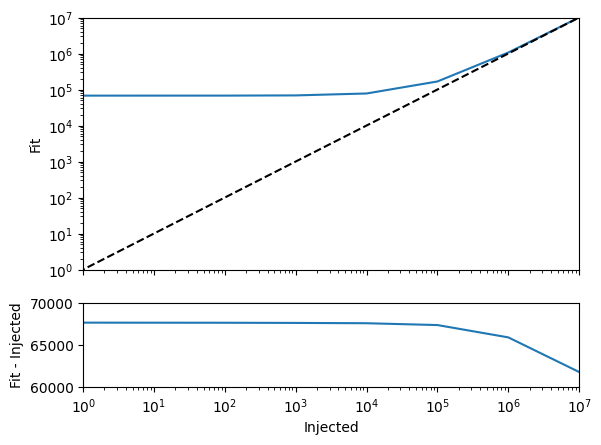

In [16]:
f, (a0, a1) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, facecolor='w')

a0.plot(ninj, nrec)
a0.plot(xs, xs, linestyle='--', c='k')
a0.loglog()
a0.set_ylabel('Fit')
a0.set_xlim(1,1e7)
a0.set_ylim(1,1e7)

a1.plot(ninj, nrec-ninj)
#a1.plot(xs, [70000, 70000], linestyle='--', c='k')
a1.set_ylabel('Fit - Injected')
a1.set_xlabel('Injected')
a1.set_ylim(60000, 70000)

plt.show()

In [ ]:
dec_mask = (bin_chilln.bin_decs <= np.radians(bin_chilln.max_dec_deg)) & (bin_chilln.bin_decs >= np.radians(bin_chilln.min_dec_deg))

In [ ]:
nss = np.logspace(0, 7.5, 500)
tss = [bin_chilln.multinomial_TS(x, bin_chilln.counts[dec_mask], bin_chilln.p_s[dec_mask], bin_chilln.p_b[dec_mask]) for x in nss]

In [ ]:
plt.figure(facecolor='w')
plt.plot(nss, tss)
plt.scatter(10061559, 614638, marker='+', color='r', label='Best Fit')
plt.ylabel('TS')
plt.xlabel('ns')
plt.legend()
#plt.semilogy()
plt.show()

<Figure size 640x480 with 0 Axes>

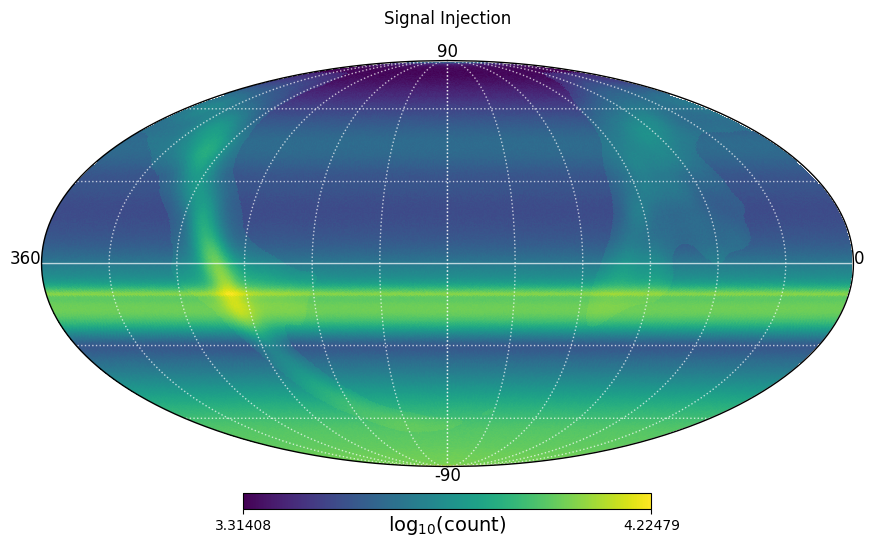

In [18]:
plt.figure(facecolor='w')

x = bin_chilln.counts

coord='C'
hp.mollview(np.log10(x), unit=r'$\log_{10}($count$)$', rot=(180,0,0))#, cmap='nipy_spectral')#, min=-3, max=1) 
hp.projtext(0,0,'90', size='large', ha='center', va='bottom', coord=coord)#, rot=rot)
hp.projtext(np.pi/2,2.0*np.pi - .001,'360', size='large', ha='right', coord=coord)#, rot=rot)
hp.projtext(np.pi/2,0,'0', size='large', ha='left', coord=coord)#, rot=rot)
hp.projtext(np.pi,0,'-90', size='large', ha='center', va='top', coord=coord)#, rot=rot)
hp.graticule(30, color='w', alpha=0.7)
plt.title('Signal Injection', pad=25)
plt.show()

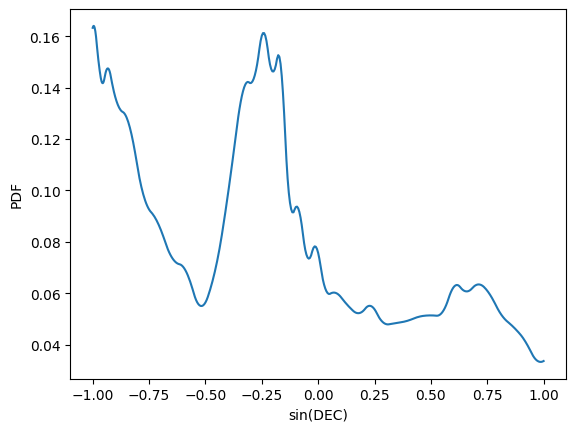

In [21]:
x = np.sin(np.unique(bin_chilln.bin_decs))
plt.plot(x, bin_chilln.get_acc_from_spline(x, acc='bg'))
plt.xlabel('sin(DEC)')
plt.ylabel('PDF')
plt.show()

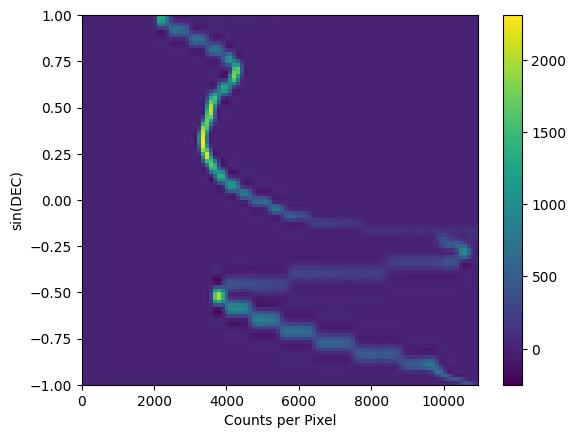

In [22]:
mask = (bin_chilln.template_pdf <= bin_chilln.cutoff)

sindec_bins = np.unique(np.concatenate([
             np.linspace(-1, -0.93, 4 + 1),
             np.linspace(-0.93, -0.3, 10 + 1),
             np.linspace(-0.3, 0.05, 9 + 1),
             np.linspace(0.05, 1, 18 + 1) ]) )
count_bins = np.linspace(0, np.quantile(bin_chilln.binned_data, 0.99), 100)
h = hl.hist((bin_chilln.binned_data[mask], np.sin(bin_chilln.bin_decs[mask])), 
            bins = (count_bins, sindec_bins))

skw = {}
skw.setdefault('s', 0)
skw.setdefault('kx', 2)
skw.setdefault('ky', 2)
s_hl = h.spline_fit(**skw)

hl.plot2d(s_hl.eval(bins=100), cbar=True)
plt.xlabel('Counts per Pixel')
plt.ylabel('sin(DEC)')
plt.show()

In [54]:
#load and append bkg trials
pfs = {}
dists = {}
cutoff = 0.1
gamma = 2.5
for where_acc in ['allsky']:

    filelist = sorted(glob(f'/data/user/mcampana/analysis/binned_tracks/trials/bkg/{where_acc}/cutoff/{cutoff}/gamma/{gamma}/trials*.npy'))
    bg_tss = np.array([])
    c = 0
    for f in filelist:
        c += 1
        arr = np.load(f, allow_pickle=True)
        bg_tss = np.append(bg_tss, np.array(list(arr.item()['results']))['ts'])

    print(f'Loaded {c} files of background trials.')

    med_bg_ts = np.median(bg_tss)

    #load and append sig trials
    #nsigs = np.sort(np.array(os.listdir(f'/data/user/mcampana/analysis/binned_tracks/trials/sig/{where_acc}/nsig/'), dtype=int))
    nsigs = np.array([5000, 10000, 15000, 20000, 25000])
    sig_tss = {}
    passing = {}
    for nsig in nsigs:
        filelist = sorted(glob(f'/data/user/mcampana/analysis/binned_tracks/trials/sig/{where_acc}/cutoff/{cutoff}/gamma/{gamma}/nsig/{nsig}/trials*.npy'))
        tss = np.array([])
        c = 0
        for f in filelist:
            c += 1
            arr = np.load(f, allow_pickle=True)
            tss = np.append(tss, np.array(list(arr.item()['results']))['ts'])

        sig_tss[nsig] = tss

        #passing fractions
        passing[nsig] = np.mean(tss > med_bg_ts)
        
    sig_tss[0] = bg_tss
    
    passing[0] = .5
    
    pfs[where_acc] = passing
    dists[where_acc] = sig_tss

print('Done')

Loaded 100 files of background trials.
Done


In [36]:
from matplotlib.cm import get_cmap
cmap = get_cmap('plasma')

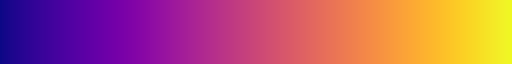

In [44]:
cmap

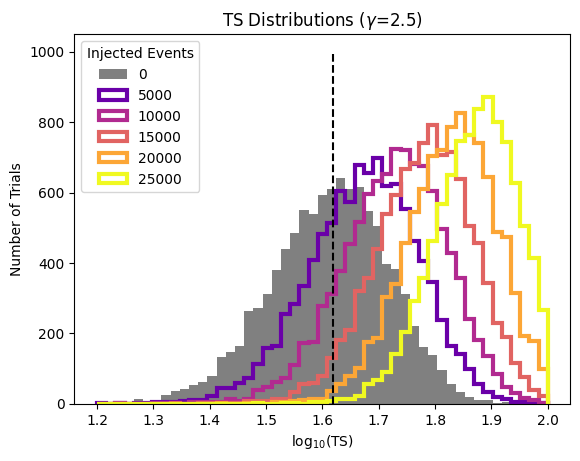

In [55]:
plt.figure(facecolor='w')
bins = np.linspace(1.2,2,50)

for where_acc in ['allsky']: #['bothAcc', 'tempAcc', 'combAcc', 'allsky']
    for nsig in np.append(np.array([0]), nsigs):
        if nsig == 0:
            plt.hist(np.log10(dists[where_acc][nsig]), label=nsig, bins=bins, color='grey')
        else:        
            plt.hist(np.log10(dists[where_acc][nsig]), label=nsig, histtype='step', linewidth=3, bins=bins, color=cmap(nsig/25000))

    plt.vlines(np.log10(np.median(dists[where_acc][0])), 0, 1000, linestyle='--', color='k')
               
#plt.xlim(0, 600)
plt.title(fr'TS Distributions ($\gamma$={gamma})')
plt.xlabel(r'$\log_{10}$(TS)')
plt.ylabel('Number of Trials')
plt.legend(title=r'Injected Events', loc='upper left')
plt.show()

In [5]:
from scipy.interpolate import interp1d, splrep, splev

In [32]:
xs = np.linspace(0,25000,500)
ys = {}
for where_acc in ['allsky']:
    passing = pfs[where_acc]
    #f = interp1d(list(passing.keys()), list(passing.values()), kind='quadratic')
    #ys[where_acc] = f(xs)
    
    dkeys = sorted(list(passing.keys()))
    sorted_passing = {i: passing[i] for i in dkeys}
    splr = splrep(list(sorted_passing.keys()), list(sorted_passing.values()), k=2, s=.0001)
    ys[where_acc] = splev(xs, splr)


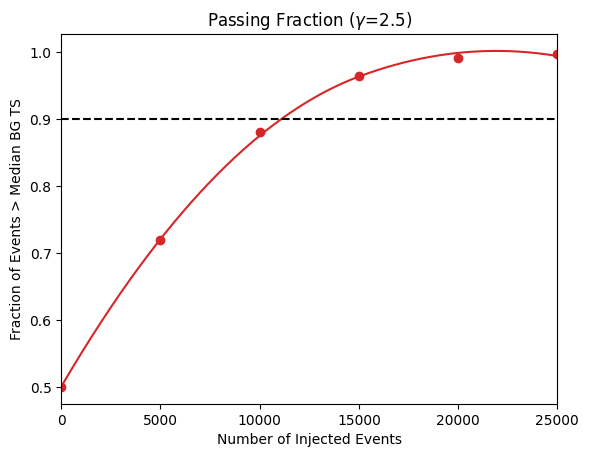

In [33]:
colors = {'bothAcc': 'C0', 'tempAcc': 'C1', 'combAcc': 'C2', 'allsky': 'C3'}

plt.figure(facecolor='w')
for where_acc in ['allsky']:
    passing = pfs[where_acc]
    plt.scatter(sorted_passing.keys(), sorted_passing.values(), label=where_acc, color=colors[where_acc])
    plt.plot(xs, ys[where_acc], color=colors[where_acc])

plt.hlines(0.9, 0, 25000, linestyle='--', color='k')
#plt.legend(title='')
plt.title(fr'Passing Fraction ($\gamma$={gamma})')
plt.xlabel('Number of Injected Events')
plt.ylabel('Fraction of Events > Median BG TS')
plt.xlim(0,25000)
plt.show()

In [35]:
splev(11000, splr)

array(0.89836522)

In [26]:
import json
import datetime as dt

with open('grl_2020.txt') as f:
    data = f.read()
    
js = json.loads(data)

form = '%Y-%m-%d %H:%M:%S.%f'
dur = 0.0
for d in js['runs']:
    if (d['good_i3'] == True) and (d['good_it'] == True):
        start = d['good_tstart'][:26]
        stop = d['good_tstop'][:26]
        
        if len(start) < 26:
            if len(start) == 19:
                start = start + '.' + 6*'0'
            else:
                start = start + (26-len(start))*'0'
                
        if len(stop) < 26:
            if len(stop) == 19:
                stop = stop + '.' + 6*'0'
            else:
                stop = stop + (26-len(stop))*'0'
        
        dt_start = dt.datetime.strptime(start, form)
        dt_stop = dt.datetime.strptime(stop, form)
        
        delta = dt_stop - dt_start
        
        dur += delta.total_seconds()

In [29]:
dur

31371977.196272973

In [28]:
ana = cy.get_analysis(cy.selections.Repository(), 'version-003-p02', cy.selections.PSDataSpecs.IC86v3_2016)

Setting up Analysis for:
IC86v3_2016
Setting up IC86v3_2016...
Reading /data/ana/analyses/ps_tracks/version-003-p02/IC86_2012_MC.npy ...
Reading /data/ana/analyses/ps_tracks/version-003-p02/IC86_2016_exp.npy ...
Reading /data/ana/analyses/ps_tracks/version-003-p02/GRL/IC86_2016_exp.npy ...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [29]:
ana = ana[:1]
ana[0].sig = cy.utils.Arrays(np.load('data/level2/sim/npy/Level2_sim.npy', allow_pickle=True))

In [36]:
#t_repo = cy.selections.Repository(local_root='./templates')
#template = t_repo.get_template('Fermi-LAT_pi0_map')
template = np.load('templates/Fermi-LAT_pi0_map.npy', allow_pickle=True)
gamma=2.7
gp_conf = {
            'template': template,
            'flux': cy.hyp.PowerLawFlux(gamma),
            'randomize': ['ra'],
            'fitter_args': dict(gamma=gamma),
            'sigsub': False,
            'update_bg': True,
            'fast_weight': False,
        }

In [37]:
tr = cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=1)

IC86v3_2016               | Acceptance weighting complete.                    
IC86v3_2016               | Smearing complete.                              


In [38]:
tr.to_E2dNdE(12000, E0=100, unit=1e3)

5.006380322403379e-10